In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
import os
import sys
import importlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import hstack, vstack

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

sys.path.append('./')
sys.path.append('./operator_position')

sys.path.append('/Users/i.tolkachev/freelance/git/softpro/')
import odds

from tqdm import tqdm_notebook

tqdm_notebook().pandas()

In [5]:
data = pd.read_excel('/Users/i.tolkachev/freelance/softpro/20191125.xlsx', sheet_name='Sheet2')

In [6]:
data_nodups = data.drop(['Id', 'DateAdded'], axis=1).drop_duplicates()

In [15]:
columns_data = [c for c in data_nodups.columns.tolist() if not ('computed' in c or 'disc' in c)]

total_columns = [c for c in columns_data if 'TO' in c or 'TU' in c]
hdp_columns = [c for c in columns_data if 'HDP' in c]

In [18]:
def fair_odd(odd, margin):
    return (odd*(margin+1))

def margin_2(odd_1, odd_2):
    return 1/odd_1 + 1/odd_2 - 1

def margin_3(odd_1, odd_2, odd_3):
    return 1/odd_1 + 1/odd_2 + 1/odd_3 - 1

# Example of odds probability fitting

In [65]:
totals_u.loc[:, 'to'] = totals[to_columns]
totals_u

,index,0,to
0,TU_1_5,2.85,NaN
1,TU_1_75,2.47,NaN
2,TU_2_0,2.08,NaN
3,TU_2_25,1.74,NaN
4,TU_2_5,1.558,NaN


In [71]:
pd.concat([totals[to_columns].reset_index(), totals[tu_columns].reset_index()], axis=1)

,index,0,index,0
0,TO_1_5,1.418,TU_1_5,2.85
1,TO_1_75,1.543,TU_1_75,2.47
2,TO_2_0,1.757,TU_2_0,2.08
3,TO_2_25,2.1,TU_2_25,1.74
4,TO_2_5,2.43,TU_2_5,1.558


In [89]:
totals

array([[2.85, 1.418],
       [2.47, 1.543],
       [2.08, 1.757],
       [1.74, 2.1],
       [1.558, 2.43]], dtype=object)

In [90]:
totals_u

array([2.85, 2.47, 2.08, 1.74, 1.558], dtype=object)

In [126]:
x = [0, 0.25, 0.5, 0.75]

coeffs = []

for i in tqdm_notebook(range(data_nodups.shape[0])):
    
    totals = data_nodups.iloc[i, :][total_columns]
    
    # find not NAN totals from line
    
    totals = totals[totals.notnull()]
    tu_columns = [c for c in totals.index if 'U' in c]
    to_columns = [c for c in totals.index if 'O' in c]
    totals_u = totals[tu_columns].values
    totals_o = totals[to_columns].values
    totals = vstack((totals_u, totals_o)).T 
    x, y = [], []
    for i, row in enumerate(totals):
        tu, to = row[0], row[1]
        margin = margin_2(to, tu)
        total_value = float(tu_columns[i][3:].replace('_', '.'))
        x.append(total_value) 
        y.append(1/fair_odd(tu, margin))

    ans = np.polyfit(x, y, 2)

    x=np.arange(x[0]-0.5, x[-1]+0.5, 0.01)
    
    def f(x):
        return sum(a*x**i for i, a in enumerate(ans))
    
    y=[f(x0) for x0 in x] 
    coeffs.append(ans)

Посмотрим на разброс коэффициентов

In [133]:
np_coeffs = np.array(coeffs)

print('Разброс, коэф при степени 0:', np.std(np_coeffs[:, 0]))
print('Разброс, коэф при степени 1:', np.std(np_coeffs[:, 1]))
print('Разброс, коэф при степени 2:', np.std(np_coeffs[:, 2]))

Разброс, коэф при степени 0: 0.01700812516549545
Разброс, коэф при степени 1: 0.1059848951289387
Разброс, коэф при степени 2: 0.2665468567752061


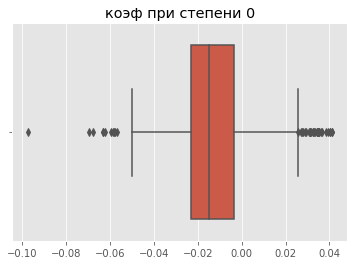

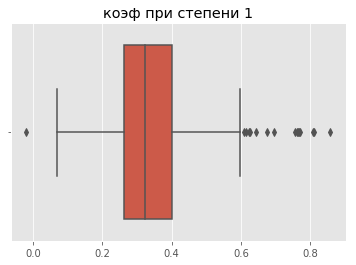

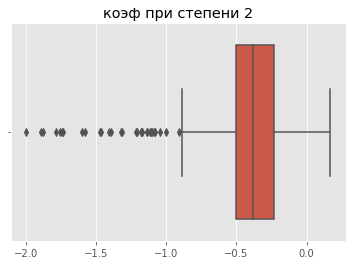

In [138]:
import seaborn as sns

sns.boxplot(np_coeffs[:, 0])
plt.title('коэф при степени 0')
plt.show()

sns.boxplot(np_coeffs[:, 1])
plt.title('коэф при степени 1')
plt.show()

sns.boxplot(np_coeffs[:, 2])
plt.title('коэф при степени 2')
plt.show()

##  Выводы
- коэффициенты имеют очевидный разброс, поэтому найти какую-то общую зависимость 
  между целыми, четвертичными и половинчатыми не удается
  
## Что можно попробовать
- посмотреть матчи, в которых есть несколько половинчатых тоталов, и приближенно решить систему уравнений,
  чтобы понять, минимизируется ли Loss до нуля для этой системы. Если нет, то получается, что вероятности 
  из разных тоталов принадлежат разным распределениям Пуассона, что опять даёт повод задуматься о возможности
  найти стабильно более точное решение.

In [141]:
data_nodups.loc[:, hdp_columns].head()

,"HOME_HDP 3,5","AWAY_HDP -3,5","HOME_HDP 3,0","AWAY_HDP -3,0","HOME_HDP 2,75","AWAY_HDP -2,75","HOME_HDP 2,5","AWAY_HDP -2,5","HOME_HDP 2,0","AWAY_HDP -2,0","HOME_HDP 1,75","AWAY_HDP -1,75","HOME_HDP 1,5","AWAY_HDP -1,5","HOME_HDP 1,0","AWAY_HDP -1,0","HOME_HDP 0,75","AWAY_HDP -0,75","HOME_HDP 0,5","AWAY_HDP -0,5","HOME_HDP 0,25","AWAY_HDP -0,25","HOME_HDP 0,0","AWAY_HDP 0,0","HOME_HDP -0,25","AWAY_HDP 0,25","HOME_HDP -0,5","AWAY_HDP 0,5","HOME_HDP -0,75","AWAY_HDP 0,75","HOME_HDP -1,0","AWAY_HDP 1,0","HOME_HDP -1,25","AWAY_HDP 1,25","HOME_HDP -1,5","AWAY_HDP 1,5","HOME_HDP -2,0","AWAY_HDP 2,0","HOME_HDP -2,25","AWAY_HDP 2,25","HOME_HDP -2,5","AWAY_HDP 2,5","HOME_HDP -2,75","AWAY_HDP 2,75","HOME_HDP -3,0","AWAY_HDP 3,0","HOME_HDP -3,25","AWAY_HDP 3,25","HOME_HDP -3,5","AWAY_HDP 3,5"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666,2.24,1.99,1.862,2.29,1.641,2.90,1.416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.645,2.28,1.97,1.877,2.27,1.649,2.87,1.423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.662,2.24,1.99,1.854,2.29,1.636,2.91,1.414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.689,2.20,2.02,1.826,2.33,1.621,2.96,1.401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.714,2.16,2.04,1.806,2.36,1.606,3.00,1.392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Proba difference on win from MoneyLine and Handicaps

In [155]:
m3 = margin_3(*ml.values)

In [198]:
hdp_win_columns = ['HOME_HDP -0,5', 'AWAY_HDP -0,5', 'HOME_HDP 0,5', 'AWAY_HDP 0,5']
ml_columns = ['HOME', 'DRAW', 'AWAY']

diff = []
large_diff = {}
for i in tqdm_notebook(range(data_nodups.shape[0])):
    
    ml = data_nodups.iloc[i, :][ml_columns]
    hdp = data_nodups.iloc[i, :][hdp_win_columns].dropna().reset_index().values
    
    # hdp proba
    margin_ml = margin_3(*ml.values)
    
    home_win_ml = 1 / fair_odd(ml['HOME'], margin_ml)
    away_win_ml = 1 / fair_odd(ml['AWAY'], margin_ml)
    

    
    for h in hdp:
        if h[0] == 'HOME_HDP -0,5':
            m = margin_2(h[1], data_nodups.iloc[i, :]['AWAY_HDP 0,5'])
            home_win_hdp = 1 / fair_odd(h[1], m)
            # calc proba diff
            d = abs(home_win_hdp - home_win_ml)

            diff.append(d)
            if d > 0.01:
                print(i, d)
                print('home win proba ml:', home_win_ml)
                print('away win proba ml:', away_win_ml)
                print('margin:', margin_ml)
                print('home win proba hdp:', home_win_hdp, 'margin:', m)
                large_diff[i] = d 
            
        if h[0] == 'AWAY_HDP -0,5':
            m = margin_2(h[1], data_nodups.iloc[i, :]['HOME_HDP 0,5'])
            away_win_hdp = 1 / fair_odd(h[1], m)
 
            # calc proba diff
            d = abs(away_win_hdp - away_win_ml)
        
            diff.append(d)
            if d > 0.01:
                print(i, d)
                print('home win proba ml:', home_win_ml)
                print('away win proba ml:', away_win_ml)
                print('margin:', margin_ml)
                print('away win proba hdp:', away_win_hdp, 'margin:', m)
                large_diff[i] = d 

173 0.020233330014564455
home win proba ml: 0.4228769497400347
away win proba ml: 0.317157712305026
margin: 0.051001821493624755
home win proba hdp: 0.40264361972547025 margin: 0.05684504620674824
236 0.014043857976673957
home win proba ml: 0.472801674714131
away win proba ml: 0.31364071490937395
margin: 0.05226454223487087
home win proba hdp: 0.48684553269080494 margin: 0.04265969206367304
390 0.014312038624435142
home win proba ml: 0.3733493667187377
away win proba ml: 0.3983434665827536
margin: 0.05037505806332043
home win proba hdp: 0.35903732809430255 margin: 0.06713629049588299
390 0.015529069890243552
home win proba ml: 0.3733493667187377
away win proba ml: 0.3983434665827536
margin: 0.05037505806332043
away win proba hdp: 0.41387253647299715 margin: 0.055110412565184896
497 0.010025982896327224
home win proba ml: 0.2826417493710779
away win proba ml: 0.49687151558713216
margin: 0.04986579549834458
away win proba hdp: 0.48684553269080494 margin: 0.04265969206367304
553 0.0189082

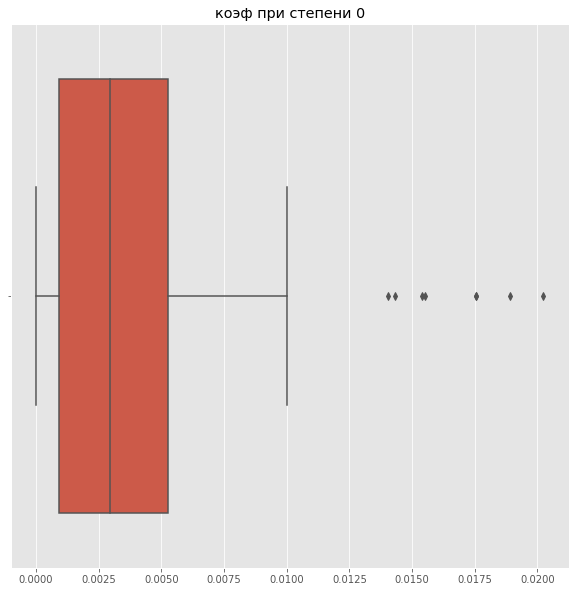

In [195]:
plt.figure(figsize=(10,10))
sns.boxplot(diff)
plt.title('коэф при степени 0')
plt.show()

In [199]:
# big errors 
for i in large_diff.keys():
    ml = data_nodups.iloc[i, :][ml_columns]
    hdp = data_nodups.iloc[i, :][hdp_win_columns]
    
    # hdp proba
    margin_ml = margin_3(*ml.values)
    
    home_win_ml = 1 / fair_odd(ml['HOME'], margin_ml)
    away_win_ml = 1 / fair_odd(ml['AWAY'], margin_ml)
    
    print('home win proba ml:', home_win_ml)
    print('away win proba ml:', away_win_ml)
    print('margin:', margin_ml)
    
    for h in hdp.dropna().reset_index().values:
        if h[0] == 'HOME_HDP -0,5':
            m = margin_2(h[1], data_nodups.iloc[i, :]['AWAY_HDP 0,5'])
            home_win_hdp = 1 / fair_odd(h[1], m)
            print('home win proba hdp:', home_win_hdp, 'margin:', m)
            
            # calc proba diff
            d = abs(away_win_hdp - away_win_ml)
            print('diff:', d)
            
        if h[0] == 'AWAY_HDP -0,5':
            m = margin_2(h[1], data_nodups.iloc[i, :]['HOME_HDP 0,5'])
            away_win_hdp = 1 / fair_odd(h[1], m)
            print('away win proba hdp:', away_win_hdp, 'margin:', m)
            
            # calc proba diff
            d = abs(away_win_hdp - away_win_ml)
            print('diff:', d)

home win proba ml: 0.4228769497400347
away win proba ml: 0.317157712305026
margin: 0.051001821493624755
home win proba hdp: 0.40264361972547025 margin: 0.05684504620674824
diff: 0.18063506879079333
home win proba ml: 0.472801674714131
away win proba ml: 0.31364071490937395
margin: 0.05226454223487087
home win proba hdp: 0.48684553269080494 margin: 0.04265969206367304
diff: 0.18415206618644536
home win proba ml: 0.3733493667187377
away win proba ml: 0.3983434665827536
margin: 0.05037505806332043
home win proba hdp: 0.35903732809430255 margin: 0.06713629049588299
diff: 0.09944931451306571
away win proba hdp: 0.41387253647299715 margin: 0.055110412565184896
diff: 0.015529069890243552
home win proba ml: 0.2826417493710779
away win proba ml: 0.49687151558713216
margin: 0.04986579549834458
away win proba hdp: 0.48684553269080494 margin: 0.04265969206367304
diff: 0.010025982896327224
home win proba ml: 0.5512672323700438
away win proba ml: 0.2603374649571718
margin: 0.05526599780968855
home w

##  Выводы
- средняя ошибка разницы moneyline и гандикапов в районе 0.3% вероятности. 
- имеются матчи с разницей вероятностей больше 1%.
- получается, что даже если будет идеальная модель, которая предсказывает гандикапы максимально точно, ошибка на 
  moneyline сохранится и будет ненулевой, так что неясно, как можно интерпретировать точность в данном случае.
  Как бы просто линия букмекерская сама содержит ошибки, поэтому не понимаю, насколько честно проверять модель 
  на недостаточно точных данных.

In [ ]:
# plot example graphs

totals = data_nodups.iloc[0, :][total_columns]

# find not NAN totals from line

totals = totals[totals.notnull()]
tu_columns = [c for c in totals.index if 'U' in c]
to_columns = [c for c in totals.index if 'O' in c]
totals_u = totals[tu_columns].values
totals_o = totals[to_columns].values
totals = vstack((totals_u, totals_o)).T 
x, y = [], []
for i, row in enumerate(totals):
    tu, to = row[0], row[1]
    margin = margin_2(to, tu)
    total_value = float(tu_columns[i][3:].replace('_', '.'))
    x.append(total_value) 
    y.append(1/fair_odd(tu, margin))

plt.figure(figsize=(8, 8))
plt.scatter(x, y)
    


ans = np.polyfit(x, y, 2)
x=np.arange(x[0]-0.5, x[-1]+0.5, 0.01)

# polynomial function
def f1(x):
    return sum(a*x**i for i, a in enumerate(ans))

y=[f1(x0) for x0 in x] 

# plot fitted curve
plt.plot(x, y)
plt.show()